# Sort and plot SVD

With this example the user can load GeoTiffs from HDFS and then explore all the features of Python packages such as [rasterio](https://github.com/mapbox/rasterio).

## Dependencies

In [56]:
#Add all dependencies to PYTHON_PATH
import sys
sys.path.append("/usr/lib/spark/python")
sys.path.append("/usr/lib/spark/python/lib/py4j-0.10.4-src.zip")
sys.path.append("/usr/lib/python3/dist-packages")

#Define environment variables
import os
os.environ["HADOOP_CONF_DIR"] = "/etc/hadoop/conf"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "ipython"

#Load PySpark to connect to a Spark cluster
from pyspark import SparkConf, SparkContext

from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
#To read GeoTiffs as a ByteArray
from io import BytesIO
from rasterio.io import MemoryFile

## Connect to Spark

In [57]:
appName = "plot_GeoTiff"
masterURL="spark://pheno0.phenovari-utwente.surf-hosted.nl:7077"

#A context needs to be created if it does not already exist
try:
    sc.stop()
except NameError:
    print("A  new Spark Context will be created.")
    
sc = SparkContext(conf = SparkConf().setAppName(appName).setMaster(masterURL))

## Support functions

In [58]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

## Read data

In [59]:
#EigenFile = open('/media/emma/emma/eScience/Results/SVD/SVD_results/V.txt', 'r')
resultDirectory = "hdfs:///user/pheno/svd/spark/BloomGridmetLeafGridmet/"
EigenVal_path = "S.csv"
eigenvalues = sc.textFile(resultDirectory + EigenVal_path)
EigenVector_path = "U.csv"
eigenvector = sc.textFile(resultDirectory + EigenVector_path)
EigenVector1_path = "V.csv"
eigenvector1 = sc.textFile(resultDirectory + EigenVector1_path)

## Retrieve index from mask

### Read mask

In [60]:
mask_path = "hdfs:///user/hadoop/usa_mask_gridmet.tif"
mask_data = sc.binaryFiles(mask_path).take(1)
mask_byteArray = bytearray(mask_data[0][1])
mask_memfile = MemoryFile(mask_byteArray)
mask_dataset = mask_memfile.open()
mask_data = np.array(mask_dataset.read()[0])
mask_memfile.close()

### Retrieve Index

In [61]:
xsize = mask_data.shape[1]
ysize = mask_data.shape[0]

index_sel = np.nonzero(mask_data)
inx_tuple = [(index_sel[1][i],index_sel[0][i]) for i in range(0,len(index_sel[0]))]

idx = [np.ravel_multi_index(inx_tuple[i], (xsize,ysize)) for i in range(0,len(inx_tuple))]
mask_data1 = np.reshape(mask_data, mask_data.shape[0]*mask_data.shape[1], 1)

## Sort eigenvalues

In [62]:
Eigenvalues=[]
for pc in range(0,26):
    list2 = eigenvalues.map(lambda line: (line.split(',')[pc])).collect()
    Eigenvalues.append(list2[pc])

In [63]:
index = sorted(range(len(Eigenvalues)))
list_eigenV = [float(Eigenvalues[index[i]]) for i in range(0, len(index))]

## Plot eigenvalues

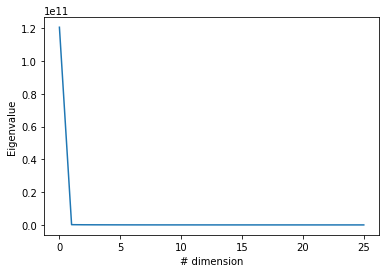

In [64]:
plt.figure(1)
plt.plot(list_eigenV)
plt.xlabel('# dimension')
plt.ylabel('Eigenvalue')
plt.show()

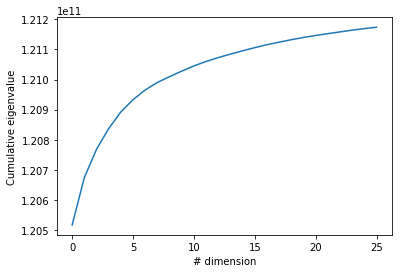

In [65]:
plt.figure(2)
img = plt.plot(np.cumsum(list_eigenV))
plt.xlabel('# dimension')
plt.ylabel('Cumulative eigenvalue')
plt.show()

## Plot images: left-singular vectors (U)

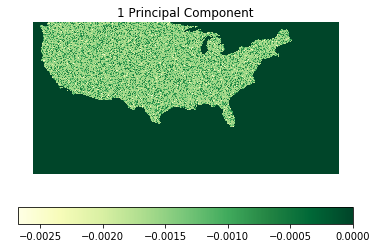

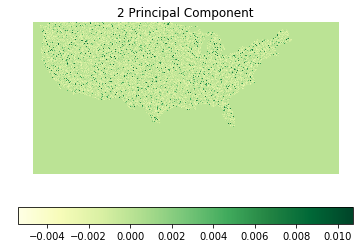

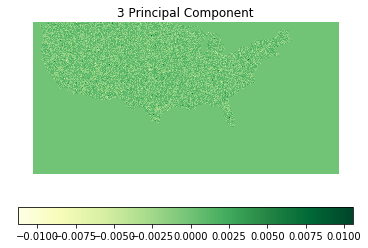

In [66]:
for pc in range(0,3):
  list2 = eigenvector.map(lambda line: (line.split(',')[index[pc]])).collect()
  mask_data_tmp = mask_data1

  # 1684x840  
  for i in range(len(idx)):
    mask_data_tmp[idx[i]]=list2[i]

  mask_data_tmp = np.reshape(mask_data_tmp,(xsize,ysize))
  #plt.figure(1)
  #plt.imshow(mask_data1.T, interpolation="None")
  #plt.show()

  plt.figure(1)
  cmap = cm.get_cmap('YlGn')
  img = plt.imshow(mask_data_tmp.T, cmap='YlGn')
  plt.colorbar(orientation='horizontal')
  plt.clim(float(np.min(mask_data_tmp.T)),float(np.max(mask_data_tmp.T)))
  plt.title(str(pc+1) + ' Principal Component')
  plt.axis('off')
  plt.show()

## Plot images: right-singular vectors (V)

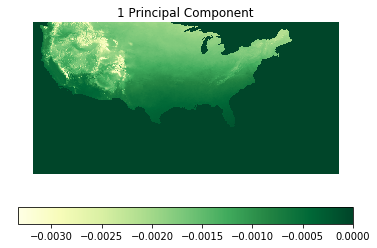

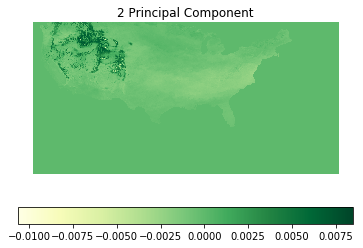

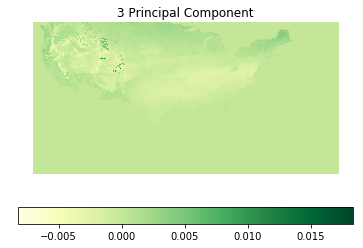

In [67]:
for pc in range(0,3):
  list2 = eigenvector1.map(lambda line: (line.split(',')[index[pc]])).collect()
  mask_data_tmp = mask_data1

  # 1684x840  
  for i in range(len(idx)):
    mask_data_tmp[idx[i]]=list2[i]

  mask_data_tmp = np.reshape(mask_data_tmp,(xsize,ysize))
  #plt.figure(1)
  #plt.imshow(mask_data1.T, interpolation="None")
  #plt.show()

  plt.figure(1)
  cmap = cm.get_cmap('YlGn')
  img = plt.imshow(mask_data_tmp.T, cmap='YlGn')
  plt.colorbar(orientation='horizontal')
  plt.clim(float(np.min(mask_data_tmp.T)),float(np.max(mask_data_tmp.T)))
  plt.title(str(pc+1) + ' Principal Component')
  plt.axis('off')
  plt.show()